# Tutorial 2 - WaveBot Optimization
The goal of this tutorial is to show a simple example of using both outer and inner optimization loops in WecOptTool. 
Like the first tutorial, it uses the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average absorbed power, while maintaining a constant volume. 
A constant volume is achieved by setting the height of the conical section (`h2`) in conjunction with the keel radius (`r2`).

This example demonstrates a complete case of the types of optimization studies WecOptTool is meant for. 
The main optimization (outer optimization loop) is to find the optimal geometry (radius `r2`), and for each geometry considered the optimal PTO force (inner optimization loop) will be found.
The inner loop was showcased in *Tutorial 1* and uses a gradient-based optimization method, with the gradients obtained with automatic differentiation. 
The outer loop optimization is for the user to setup. 
Note however that automatic differentiation is not an option due to the presence of the inner optimization loop. 
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute`.  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg)

In [1]:
import os
import logging
from datetime import datetime

import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot


logging.basicConfig(level=logging.ERROR)

results_super_dir = 'results_tutorial_2'
if not os.path.exists(results_super_dir):
    os.makedirs(results_super_dir)


## Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

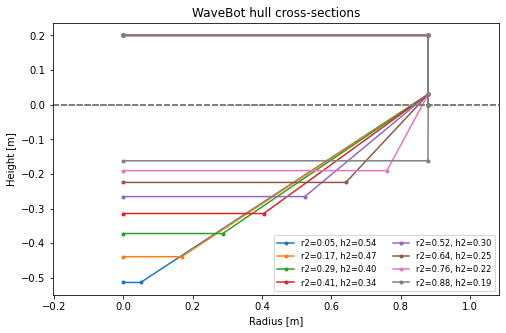

In [2]:
r1 = 0.88
r2_0 = 0.35
h2_0 = 0.37
V0 = 1/3*np.pi*h2_0*(r1**2+r2_0**2+(r1*r2_0))

r2_vals = np.linspace(0.05, 0.88*0.999, 8, endpoint=True)


def h2_from_r2(r2, V=V0, r1=r1):
    h2 = V/(1/3*np.pi*(r1**2+r2**2+(r1*r2)))
    return h2


# plot
mapres = map(h2_from_r2, r2_vals)
h2_vals = list(mapres)

fig1, ax1 = plt.subplots(figsize=(8,5))
for r2, h2 in zip(r2_vals.tolist(), h2_vals):
    _ = wot.geom.WaveBot(r2=r2, h2=h2, freeboard=0.2).plot_cross_section(
        ax=ax1, label=f"r2={r2:.2f}, h2={h2:.2f}")
ax1.legend(loc='best', fontsize='small',ncol=2)
_ = ax1.set_title('WaveBot hull cross-sections')


Next we will define an objective function for our design optimization problem. We use the same workflow illustrated in Tutorial 1 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which can set `r2` and (indirectly) `h2`.

In [3]:
def design_obj_fun(x):
    r2 = x[0]
    print(f"\nr2 = {r2:.2f}:")
    start_time = datetime.now()
    
    ## WEC ##
    # geometry
    h2 = h2_from_r2(r2)

    # mesh
    wb = wot.geom.WaveBot(r2=r2, h2=h2)
    mesh = wb.mesh(mesh_size_factor=0.5)

    # capytaine floating body (mesh + DOFs)
    fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
    fb.add_translation_dof(name="Heave")
    ndof = 1
    
    # mass & hydrostatic stiffness
    stiffness = wot.hydrostatics.stiffness_matrix(fb).values
    mass = wot.hydrostatics.inertia_matrix(fb).values

    # frequencies
    f1 = 0.05
    nfreq = 50

    # Impedance stuff
    omega = wot.frequency(f1, nfreq, False) * 2 * np.pi
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_inertia = 2.0
    drivetrain_friction = 1.0
    drivetrain_stiffness = 0.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + 
                            1/(1j*omega)*drivetrain_stiffness) 

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

    # PTOs (additional force + constraint + objective function)
    name = ["PTO_Heave",]
    kinematics = np.eye(ndof)
    efficiency = None
    controller = None
    pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, efficiency, name)

    # constraints at 4x points
    nsubsteps = 4
    f_max = 2000.0

    def const_f_pto(wec, x_wec, x_opt):
        f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq',
                 'fun': const_f_pto,
                 }
    constraints = [ineq_cons]

    # additional friction
    dissipation = 160.3

    # create WECs
    f_added = {'PTO': pto.force_on_wec}

    wec = wot.WEC.from_floating_body(fb=fb,
                                     f1=f1,
                                     nfreq=nfreq,
                                     inertia_matrix=mass,
                                     hydrostatic_stiffness=stiffness,
                                     wave_directions=[0],
                                     friction=dissipation,
                                     f_add=f_added,
                                     constraints=constraints,
                                     rho=1e3,
                                     depth=6.1,
                                     )

    ## WAVE ##
    wfreq = 0.6
    amplitude = 0.0625
    phase = -40
    waves = wot.waves.regular_wave(f1, nfreq, wfreq, amplitude, phase)

    ## OBJECTIVE FUNCTION ##
    obj_fun = pto.average_power
    ncomponents_pto = 2 * nfreq + 1

    ## SOLVE ##
    scale_x_opt = 1
    res_fd, res_td, res = wec.solve(
        waves, obj_fun, ncomponents_pto, scale_x_opt=scale_x_opt)
    
    print(f'time (hh:mm:ss): {datetime.now()-start_time}')

    return res.fun


## Solve
Finally, we may call this objective function with an optimization algorithm. 
Here, a simple *brute force* optimization approach is used for illustrative purposes, but any variety of options could be applied. 
The optimization algorithm will call our objective function, which in turn will create a new WaveBot hull, run the necessary BEM calculations for the hull, and find the PTO force that provides the most absorbed power for that hull. 
This process will be conducted for the range of `r2` values that we specify.

In [4]:
# range over which to search
ranges = (slice(r2_vals[0], r2_vals[-1]+np.diff(r2_vals)[0], np.diff(r2_vals)[0]),)

# solve
res = brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None)


r2 = 0.05:


INFO:capytaine.bodies.bodies:Stored 1304 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.hydrostatics:Using the geometric centroid as the center of gravity (COG).
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:wecopttool.hydrostatics:Setting the mass to the displaced mass.
INFO:wecopttool.core:Running Capytaine (BEM): 51 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=6.1, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=6.1, radiating_dof=Heave).
INFO:capytaine.bem.solver:Solve DiffractionProb

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['radiating_dof', 'influenced_dof'], 160.3) to Variable.

## Results
From a quick plot of the results, we see that the power absorption (where negative power is power absorbed by the device) generally improves for smaller values of `r2`.
It is also clear that when the WEC is cylindrical (where `r2=0.88`), power absorption is reduced.

In [ ]:
fig2, ax2 = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(res[2])]

ax2.plot(res[2], res[3], 'k', zorder=0)
ax2.scatter(res[2], res[3], c=colors, zorder=1)

ax2.set_xlabel('Keel radius, $r_2$ [m]')
ax2.set_ylabel('Average Power [W]')
ax2.set_title('Design optimization results')
fig2.tight_layout()

plt.show()